In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [3]:
# 讀取數據
data = pd.read_csv('seattle-weather.csv')

# 檢查數據結構
print(data.head())
print(data.info())
print(data.isnull().sum())

# 定義訓練集和測試集的比例
TRAIN_TEST_SPLIT = 0.8

# 計算拆分點
date_len = len(data)
split = int(date_len * TRAIN_TEST_SPLIT)

# 按比例切分數據
train_data = data.iloc[:split]  # 前 80% 為訓練集
test_data = data.iloc[split:]   # 後 20% 為測試集

# 驗證切分結果
print(f"總數據長度: {date_len}")
print(f"訓練集長度: {len(train_data)}")
print(f"測試集長度: {len(test_data)}")

# 驗證切分後的形狀
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# 如果有目標列，分離特徵與目標
if 'weather' in data.columns:
    train_features = train_data.drop('weather', axis=1)
    train_labels = train_data['weather']
    test_features = test_data.drop('weather', axis=1)
    test_labels = test_data['weather']

    print(f"Train features shape: {train_features.shape}")
    print(f"Train labels shape: {train_labels.shape}")
    print(f"Test features shape: {test_features.shape}")
    print(f"Test labels shape: {test_labels.shape}")

         date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB
None
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weath

In [4]:
# 提取特徵和目標
weather_data = data[['precipitation', 'temp_max', 'temp_min', 'wind']].values
weather_categories = data['weather'].values

# 編碼天氣類別
label_encoder = LabelEncoder()
weather_labels = label_encoder.fit_transform(weather_categories)
print(f"Weather categories: {label_encoder.classes_}")

# 設定窗口參數
WINDOW_LENGTH = 5
WINDOW_STEP = 1

# 檢查窗口長度是否合理
if WINDOW_LENGTH >= len(weather_data):
    raise ValueError("WINDOW_LENGTH must be smaller than the data length.")

# 建立訓練資料與目標
train_data, test_data = [], []
for i in range(0, len(weather_data) - WINDOW_LENGTH, WINDOW_STEP):
    train_data.append(weather_data[i: i + WINDOW_LENGTH])
    test_data.append(weather_labels[i + WINDOW_LENGTH])

# 轉換為 NumPy 陣列
train_data = np.array(train_data)
test_data = np.array(test_data)

# 打印檢查
print(f"Train data shape: {train_data.shape}")  # (樣本數, 窗口長度, 特徵數)
print(f"Targets shape: {test_data.shape}")       # (樣本數,)
print(f"Sample targets (encoded): {test_data[:5]}")

# One-Hot 編碼
test_data_one_hot = to_categorical(test_data)
print(f"Targets (one-hot):\n{test_data_one_hot[:5]}")


Weather categories: ['drizzle' 'fog' 'rain' 'snow' 'sun']
Train data shape: (1456, 5, 4)
Targets shape: (1456,)
Sample targets (encoded): [2 2 4 2 2]
Targets (one-hot):
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [5]:
# 優化器設定
optimizer = Adam(learning_rate = 0.0005)
# 建構模型
model = Sequential()
# 第1層 LSTM，指定正確的輸入形狀
model.add(LSTM(128, activation='sigmoid',input_shape=(WINDOW_LENGTH, train_data.shape[2]), 
               return_sequences=True, dropout=0.5))
model.add(BatchNormalization())
# 第2層 LSTM
model.add(LSTM(128, dropout=0.5))
model.add(BatchNormalization())
# 全連接層，輸出一個值
model.add(Dense(1, activation='linear'))
# 編譯模型
model.compile(loss='mean_squared_error', optimizer=optimizer)

# 顯示模型結構
model.summary()

# 訓練模型
history = model.fit(train_data, test_data, validation_split=0.1,  # 5% 的驗證集
                    batch_size = 32,  # 批次大小
                    epochs = 100,         # 訓練次數
                    verbose = 2,        # 顯示訓練過程
                    shuffle = True)     # 打亂訓練資料


/opt/anaconda3/envs/ENV01/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,833 (784.50 KB)

 Trainable params: 200,321 (782.50 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100
41/41 - 2s - 49ms/step - loss: 9.3102 - val_loss: 6.7108
Epoch 2/100
41/41 - 0s - 6ms/step - loss: 7.3731 - val_loss: 4.7840
Epoch 3/100
41/41 - 0s - 6ms/step - loss: 5.7698 - val_loss: 3.6350
Epoch 4/100
41/41 - 0s - 6ms/step - loss: 4.6308 - val_loss: 3.2864
Epoch 5/100
41/41 - 0s - 6ms/step - loss: 3.6551 - val_loss: 2.2556
Epoch 6/100
41/41 - 0s - 6ms/step - loss: 2.7396 - val_loss: 1.8295
Epoch 7/100
41/41 - 0s - 6ms/step - loss: 2.1911 - val_loss: 1.6215
Epoch 8/100
41/41 - 0s - 6ms/step - loss: 1.7905 - val_loss: 1.6229
Epoch 9/100
41/41 - 0s - 6ms/step - loss: 1.7968 - val_loss: 1.3450
Epoch 10/100
41/41 - 0s - 6ms/step - loss: 1.7924 - val_loss: 1.3374
Epoch 11/100
41/41 - 0s - 6ms/step - loss: 1.6581 - val_loss: 1.3748
Epoch 12/100
41/41 - 0s - 6ms/step - loss: 1.6291 - val_loss: 1.3190
Epoch 13/100
41/41 - 0s - 6ms/step - loss: 1.6352 - val_loss: 1.3049
Epoch 14/100
41/41 - 0s - 6ms/step - loss: 1.6903 - val_loss: 1.3161
Epoch 15/100
41/41 - 0s - 6ms/step - loss:

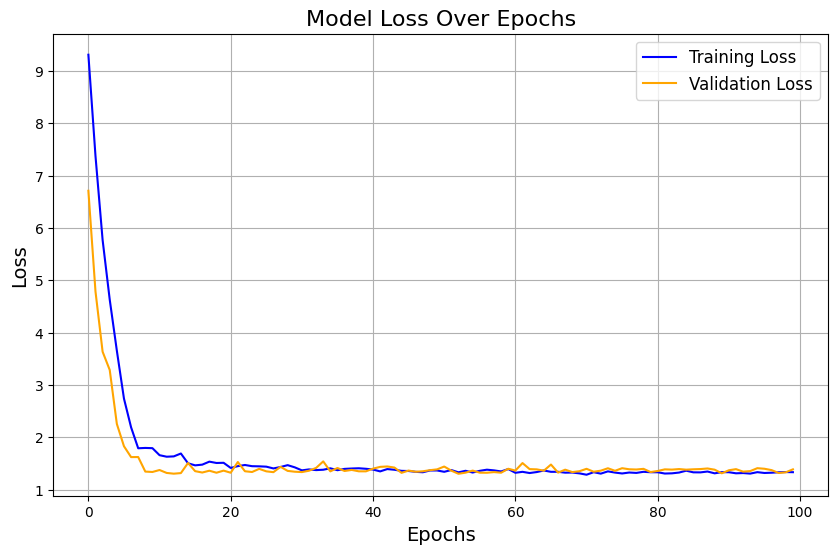

In [6]:
# 繪製訓練與驗證的損失
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


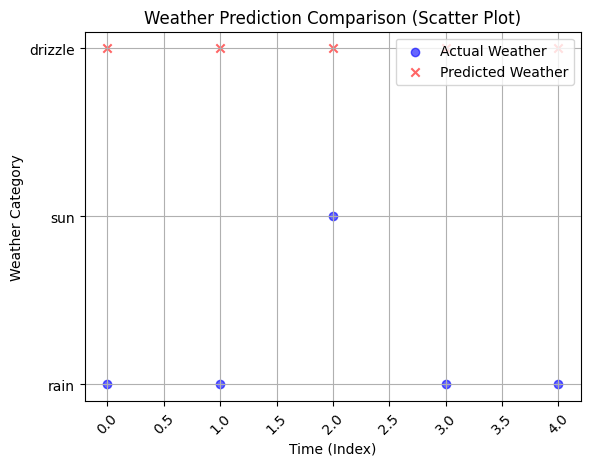

In [7]:
predictions = model.predict(train_data)

# 將預測結果轉換為數字標籤
predicted_weather = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# 將 One-Hot 編碼還原為數字標籤，然後轉為原始標籤
actual_weather_indices = np.argmax(test_data_one_hot, axis=1)  # 還原類別索引
actual_weather = label_encoder.inverse_transform(actual_weather_indices)

# 使用散點圖顯示實際結果（藍色圓點）和預測結果（紅色圓點）
plt.scatter(range(5), actual_weather[:5], label="Actual Weather", color='b', alpha=0.6, marker='o')
plt.scatter(range(5), predicted_weather[:5], label="Predicted Weather", color='r', alpha=0.6, marker='x')

# 標題和標籤
plt.title("Weather Prediction Comparison (Scatter Plot)")
plt.xlabel("Time (Index)")
plt.ylabel("Weather Category")
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()